In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 95% Confidence Intervals (Video Lecture)
* Interval of **estimates of a parameter**
* Based on random sampling
* 95% is called the confidence level (could be any % between 0 to 100)
    * Greater number means wider interval, meaning the greater chance that the interval would contain the parameter
    * But wider interval means less accuracy
* Meanwhile, lower number means smaller interval, meaning the lower chance that the interval would contain the parameter
    * But it has greater accuracy
* The **confidence** is the process that generated the interval
    * The entire processes, **population** to **sample** to **bootstraps** to **confidence intervals**, if we repeat these processes multiple times, it will generate a **good** interval about 95% of the time
    * **"Good"** means containing the parameter

### Imporant Note
* "Generates a **good** interval about 95% of the time"
    * Meaning 95% of **samples from population** will result in a good 
    * **NOT** 95% of resamples (bootstrap samples)!
* If the original sample is way off, the interval will also be way off

## [Confidence Intervals](https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals) (Inferential Thinking - 13.3)
In previous lecture, we have developed a method for estimating a parameter by using random sampling and the bootstrap. The method generates an interval of estimates, taking into account the variability in the random sample. From the example in previous lecture, we saw that our process of estimation produced a **good interval** (def: one that contains the parameter) about 95% of the time. We say that **we are 95% confident that the process results in a good interval**.

* Our estimates of interval is called **a 95% confidence interval** for the parameter
* 95% is called the **confidence level** of the interval

The previous example didn't resemble a good real-life example because we happened to know the value of the parameter. This way, we were able to 
* Check whether an interval was good or a dud
* See that our process of estimation captured the parameter about 95 out of 100 times 

In real-life, data scientists don't know the value of the parameter, which is the main reason they want to estimate it. In such situations, they provide an interval of estimates for the unknown parameter by using methods like the one we have developed. Because of statistical theory and demonstrations like the one we have seen, data scientists can be confident that their process of generating the interval results in a good interval a known percent of the time.

## Confidence Interval for a Population Median: Bootstrap Percentile Method
We'll now use the bootstrap method to estimate an unknown population median. The data come from a sample of newborns in a large hospital system. We'll treat it as if it were a simple random sample though the sampling was done in multiple stages. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) by Deborah Nolan and Terry Speed has details about a larger dataset from which this was drawn.

The table `baby` contains the following info:
* The baby's birth weight
* The number of gestational days
* The mother's age in completed years
* The mother's height (inches)
* Pregnancy weight in pounds
* Whether the mother smoked during pregnancy

In [2]:
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Birth weight is an important factor for health of a newborn infant:
* Smaller babies tend to need more medical care in their first days than larger newborns
* Thus it's helpful to have an estimate of birth weight before the baby is born

One way of doing this is by examining the relationship between birth weight and the number of gestational days. We can simply calculate **the ratio of birth weight to the number of gestational days**. 

The table `ratios` contains the first 2 columns of `baby` and an additional **ratio** column. 

In [3]:
ratio = baby.select('Birth Weight', 'Gestational Days').with_column(
'Ratio BW/GD', baby.column(0)/ baby.column(1))
ratio

Birth Weight,Gestational Days,Ratio BW/GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


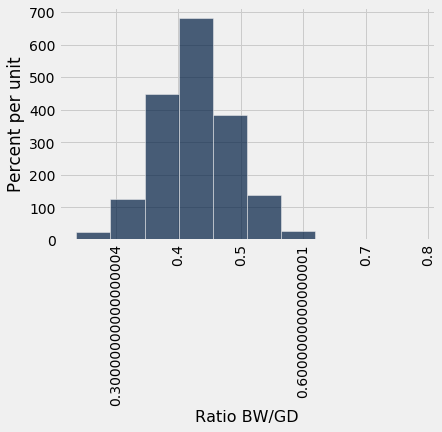

In [4]:
ratio.select(2).hist()

At a glance, the histogram look symmetric, with the most values around 0.4 to 0.45 ounces per day. However, if we look closer, some of the ratios is large by comparison. The maximum value of the ratios is over 0.78 ounce/day, almost double the typical value.

In [5]:
max(ratio.column('Ratio BW/GD'))

0.7837837837837838

The median gives a sense of the typical ratio since it is unaffected by the very large or very small ratios.

In [6]:
np.median(ratio.column('Ratio BW/GD'))

0.42907801418439717

But **this is not the median of the population**. Therefore, we are going to estimate it. The method for estimating it will be the same as before:

* Bootstrap the sample 5,000 times
    * Resulting in 5,000 estimates of the median
* Our 95% confidence interval will be the **middle 95%** of all the estimates.

We'll use the function `bootstrap_median` from previous section and construct a 95% confidence interval for the median ratio in the population.

In [7]:
def bootstrap_median(original_sample, label, repetition):
    """Returns an array of bootstrapped sample medians.
    original_sample : table containing original sample
    label: The label of the column containing the values to be processed
    repetition: The number of medians produced"""
    
    original_sample_column = original_sample.select(label)
    medians = make_array() # This will be the return result
    for i in np.arange(repetition):
        bootstrap_sample = original_sample_column.sample()
        # bootstrap_sample is in form of a table, not an array yet!
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)
    
    # Return the medians array
    return medians

In [8]:
# Generate the medians from 5,000 bootstrap samples
bootstrapped_medians = bootstrap_median(ratio, 'Ratio BW/GD', 5000)

In [9]:
# Get the endpoint
left = percentile(2.5, bootstrapped_medians)
right = percentile(97.5, bootstrapped_medians)

make_array(left, right)

array([0.42545455, 0.43262411])

To visualize the result, let's draw the empirical histogram of our bootstrapped medians and place the confidence interval on the horizontal axis.

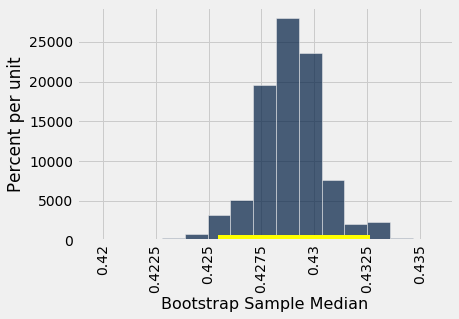

In [10]:
resampled_medians = Table().with_column(
'Bootstrap Sample Median', bootstrapped_medians
)
resampled_medians.hist(bins = 15)
plt.plot(make_array(left, right), make_array(0, 0), color = 'yellow', lw = 10);
#lw = line width

Notice that there's no red dot showing where the parameter is, unlike the previous example. Instead, we only have a 95% confidence interval of estimates, since **the process that generates it produces a good interval about 95% of the time**. This is certainly better than guessing at random.

## Confidence Interval for a Population Mean: Bootstrap Percentile Method

In the example above, the parameter is the median. We can do the same thing with the **mean** as the parameter. Suppose we want to **estimate the average age of the mothers in the population**. A natural estimate is **the average age of the mothers in the sample**.

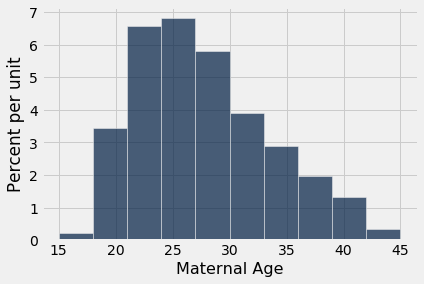

In [12]:
baby.select('Maternal Age').hist()

In [13]:
np.mean(baby.column('Maternal Age'))

27.228279386712096

Above is the average age of the mothers **in the sample**. We don't know the average age of the mothers in the population.

We'll define the function `bootstrap_mean`, which is similar to `bootstrap_median`.

In [20]:
def bootstrap_mean(original_sample, label, repetitions):
    """ Returns an array of bootstrapped sample means
    original_sample: table containing the original sample
    label: label of column containing the variable
    repetitions: number of repetition"""
    original_table_column = original_sample.select(label)
    means = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = original_table_column.sample()
        resampled_mean = np.mean(bootstrap_sample.column(0))
        means = np.append(means, resampled_mean)
        
    return means

In [21]:
# 5000 Repetitions, so 5000 values of mean!
bstrap_means = bootstrap_mean(baby, 'Maternal Age', 5000)

# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([26.90034072, 27.56729131])

Notice how close the 2 ends are to the average of about 27.2 years in the original sample. The sample size is large - 1,174 mothers - and thus the sample averages don't vary much. 

The empirical histogram of the 5,000 bootstrapped means is shown below, along with the 95% confidence interval for the population mean.

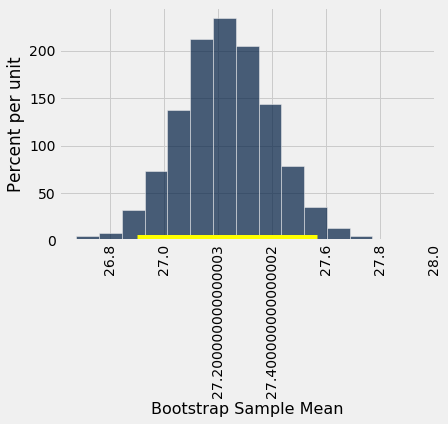

In [24]:
resampled_means = Table().with_column(
'Bootstrap Sample Mean', bstrap_means)

resampled_means.hist(bins = 15)
plt.plot(make_array(left, right), make_array(0, 0), color = 'yellow', lw = 11)

Once again, the average of the original sample (27.23 years) is close to the center of the interval. This is because each bootstrapped sample is drawn from the same original sample. The averages of the bootstrapped samples are symmetrically distributed on either side of the average of the sample from which they were drawn.

Notice that the empirical histogram of the resampled mean above has a symmetric bell shape, unlike the histogram of the sampled ages.

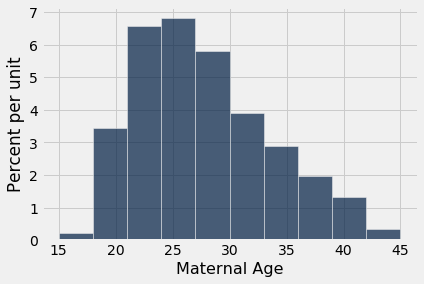

In [25]:
baby.select('Maternal Age').hist()

This is a consequence of the **Central Limit Theorem of probability and statistics**, which will be covered later.

## A 80% Confidence Interval

We can use the bootstrapped sample means to construct **an interval of any level of confidence**. For example, to construct an 80% confidence interval for the mean age in the population, we take the **middle 80%** of the resampled means. Thus, we want 10% of the distribution in each of the 2 tails, and hence the endpoints would be the 10th and 90th percentiles of the resampled means.

In [26]:
left_80 = percentile(10, bstrap_means)
right_80 = percentile(90, bstrap_means)
make_array(left_80, right_80)

array([27.01277683, 27.44804089])

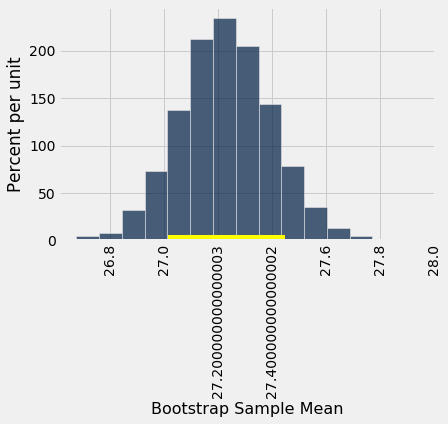

In [27]:
resampled_means.hist(bins=15)
plt.plot(make_array(left_80, right_80), make_array(0, 0), color = 'yellow', lw = 10)

Above, we see that the interval is shorter than the 95% confidence interval. The earlier process produced a wider interval but we had more confidence in the process that generated it. To get a narrow confidence interval at a high level of confidence, we need to have a larger sample.

## Confidence Interval for a Population Proportion: Bootstrap Percentile Method
From the original sample, about 39% of the mothers smoked during pregnancy.

In [28]:
baby.where('Maternal Smoker', are.equal_to(True)).num_rows/baby.num_rows

0.3909710391822828

Another way of calculating above is as the following.

In [29]:
smoking  = baby.column('Maternal Smoker')
# np.count_nonzero counts +1 for every 'True' value
np.count_nonzero(smoking) / len(smoking)

0.3909710391822828

Again, above is the percentage of mothers who smoked during pregnancy **based on the sample, not the population**. We'll use the same method as before to estimate the percentage in population.

We will start by defining a function `bootstrap_proportion` that returns an array of bootstrapped sample proportions. The only difference in computation is that we replaced the median of the resample with the proportion of smokers in it.

In [31]:
def bootstrap_proportion(original_sample, label, repetitions):
    """ Returns an array of bootstrapped sample proportions:
    original_sample: table containing the original sample
    label: label of column containing the Boolean variable
    repetitions: number of repetition
    """
    
    original_sample_column = original_sample.select(label)
    proportions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = original_sample_column.sample()
        resample_array = bootstrap_sample.column(0)
        resampled_proportion = np.count_nonzero(resample_array) / len(resample_array)
        proportions = np.append(proportions, resampled_proportion)
        
    return proportions

We'll use `bootstrap_proportion` to construct an approximate 95% confidence interval for the percent of smokers among the mothers in the population.

In [33]:
# 5000 Repetitions!
bstrap_props = bootstrap_proportion(baby, 'Maternal Smoker', 5000)

# Endpoints
left = percentile(2.5, bstrap_props)
right = percentile(97.5, bstrap_props)

make_array(left, right)

array([0.3637138 , 0.41822828])

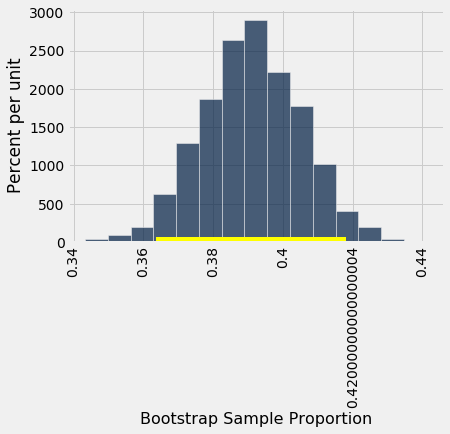

In [34]:
resampled_proportions = Table().with_column(
'Bootstrap Sample Proportion', bstrap_props)

resampled_proportions.hist(bins = 15)
plt.plot(make_array(left, right), make_array(0, 0), color = 'yellow', lw = 10)

## Care in Using Bootstrap
The bootstrap is an elegant and powerful method. Before using it, it is important to keep some points in mind.

1. Start with a large random sample
    * If not, the method might not work
    * The success rate is based on large random samples (and hence also resamples from the sample) resembling the population
    * The Law of Averages states that this is likely to be true provided the random sample is large
2. To approximate the probability distribution of a statistic, it is a good idea to replicate the resampling procedure as many times as possible.
    * We used 5,000 replications in examples, but would recommend 10,000 in general
    * A few thousand replications will result in decent approximations to the distribution of sample median, especially if the distribution of the population has one peak and is not very asymmetric
3. The bootstrap percentile method works well for estimating the population median or mean based on a large random sample. However, it has its own limitations: it is not expected to do well in the following situation:
    * The goal is to estimate the minimum or maximum value in the population, or a very low or very high percentile, or parameters that are greatly influenced by rare elements of the population
    * The probability distribution of the statistic is not roughly bell shaped
    * The original sample is very small (e.g. less than 10 or 15).

## When NOT to Use Bootstrap (Video Lecture)
The bootstrap percentile method works well for estimating the population median or mean based on a large random sample. However, it has its own limitations. The method will not produce good estimation in the following cases:
1. Estimate a very high (e.g. 90th) or very low percentile, or min and max
    * The bootstrap depends on having a sample that's representative of the population
    * In this case, we're looking at the tails of the distribution
    * Chances are, we won't see the value at all
2. Estimate any parameter that's greatly affected by rare elements of the population
    * Let's say we're trying to estimate the median
    * If the distribution is U-shaped, we won't get the estimated median of the distribution as much because it does not appear very often
3. If the probability distribution of the statistic is not roughly bell-shaped (the shape of the empirical distribution will be a clue)
    * 95% confidence interval works (shave off the 2.5% left end and 2.5% right end) because we assumed that the distribution is symmetrical
4. If the original sample is very small